## setting 
- 1. In the menu bar, select Runtime -> Change Runtime Type. Set runtime as gpu
- 2. Sync Shirley's APS 490 folder in your drive.

## import data

# (static pressure, fan speed，damper positions from all VAV boxs) - > static pressure

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install torch==1.10.0
!pip install kats
!pip install gdown
import torch.nn as nn
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm
import os
import random

# folder_path = r'C:\Users\chuiy\Documents\CPPIB 17th Floor_20211014-153532'
# savefile_path = r'C:\Users\chuiy\Documents\merged_data'
folder_path = r'/content/drive/MyDrive/APS490/Datasets/CPPIB 17th Floor_20211014-153532'
savefile_path = r'/content/drive/MyDrive/APS490/Datasets/'
savefile_name = r'merge_CPPIB_17th.csv'

slash = '/'

if not os.path.exists(savefile_path+slash+ savefile_name):
  os.chdir(folder_path)
  file_list = []
  for file_name in os.listdir():
    if file_name.endswith(".csv"):
      file_list.append(file_name)

  df = pd.read_csv(folder_path +slash+ file_list[0])
  df.to_csv(savefile_path+slash+ savefile_name,encoding="utf_8_sig",index=False)
  for i in range(1,len(file_list)):
      df = pd.read_csv(folder_path + slash+ file_list[i])
      df.to_csv(savefile_path+slash+ savefile_name,encoding="utf_8_sig",index=False, header=False, mode='a+')
else:
  print("File already exists. Loaded data from CSV")


     |████████████████████████████████| 6.3 MB 4.4 MB/s 
     |████████████████████████████████| 934 kB 49.4 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
     |████████████████████████████████| 310 kB 56.4 MB/s 
     |████████████████████████████████| 3.3 MB 40.6 MB/s 
     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 9.8 MB 20.3 MB/s 
     |████████████████████████████████| 26.3 MB 63.4 MB/s 
     |████████████████████████████████| 325 kB 57.9 MB/s 
  Created wheel for kats: filename=kats-0.1.0-py3-none-any.whl size=286607 sha256=150808565c6979f9b87dfcbfaafab6dbb65bfc149920188446ef277acf8cf19f
  Stored in directory: /root/.cache/pip/wheels/c8/dd/5b/cc7cb7fc37c5b838c65e504437bba4c1828a3fbb473c0c11be
  Created wheel for fbprophet: filename=fbprophet-0.7-py3-none-any.whl size=6637299 sha256=ec2cce9fdc17be431a78b9beba28c1bccd4005dc9ffec011e02ca3da34879e87
  Stored in directory: /root/.cache/pip/wheels/82/e8/a8/53f37f0a409bc5

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## GPU info

In [4]:
!nvidia-smi 

Sat Dec 18 17:38:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
file_name = savefile_path + slash + savefile_name
df = pd.read_csv(file_name)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,14,16,30,44,58,72,86,100,114,128,142,156,170,184,198,212,226,240,254,268,282,296,310,324,338,352,366,380,394,408,422,436,450,464,478,492,506,520,534,548,562,576,590,604) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:

date = 'DateTime'
input1 = 'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Supply Fan.Speed'
input2 = 'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Discharge Air.Static Pressure'
input3 = 'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Discharge Air.Static Pressure Setpoint'
input_list = [input1, input2]
input_list += [para for para in list(df) if para.endswith('Primary Air Damper.Damper Position')]
# dataset file name
df_input = df[input_list]
df_input = df_input.dropna()

In [7]:
df_date_input = df[[date, input1, input2, input3]]
df_date_input = df_date_input.dropna()

## curve of parameter
** just have a glance at data. it is not related to other parts of codes

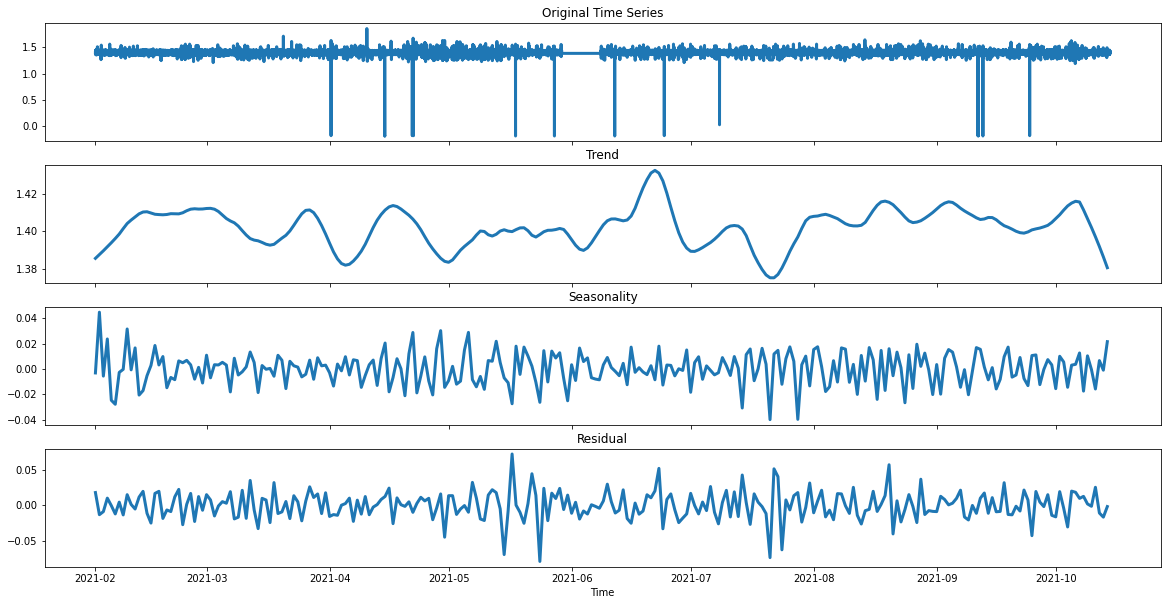

In [8]:
from kats.consts import TimeSeriesData

# Construct TimeSeriesData object
df_date_out = df[[date, input2]].dropna()
df_date_out = df_date_out.rename(columns={date: 'time', input1: 'value'})
ts = TimeSeriesData(df_date_out)
from kats.utils.decomposition import TimeSeriesDecomposition

decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

In [9]:

from kats.detectors.seasonality import FFTDetector

fft_detector = FFTDetector(ts)
s = fft_detector.detector()['seasonalities']

hours = [i/12 for i in s]
print(hours[::-1])
days = [i/288 for i in s]
print(days[::-1])
weeks = [i/(288*7) for i in s]
print(weeks[::-1])


[5.8934518091578605, 6.661328266377126, 8.689919735599622, 12.196984758117958, 12.546182685753237, 13.395378457059678, 14.469536163522013, 16.76252276867031, 17.18510737628385, 21.376596980255513, 27.7605580693816, 29.63808373590982, 33.89548802946593, 35.877680311890835, 41.73526077097505, 49.87872628726287, 51.992231638418076, 54.29277286135693, 56.80632716049382, 63.24828178694157, 65.26684397163119, 73.03670634920634, 77.65928270042194, 86.40962441314554, 97.38227513227514, 157.30982905982904, 180.44362745098036, 197.9059139784946, 211.55459770114942, 383.4427083333333, 557.7348484848485, 1227.0166666666667]
[0.2455604920482442, 0.2775553444323802, 0.36207998898331756, 0.508207698254915, 0.5227576119063849, 0.5581407690441532, 0.6028973401467506, 0.6984384486945961, 0.7160461406784937, 0.8906915408439797, 1.1566899195575666, 1.2349201556629092, 1.412312001227747, 1.4949033463287849, 1.7389691987906273, 2.078280261969286, 2.1663429849340865, 2.2621988692232056, 2.366930298353909, 2.

## ML Modeling

In [10]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

# seq_length = 48
# pred_length = 2
# train_size = 55000

In [11]:
def sliding_windows(data, seq_length, pred_length, sc):
    x = []
    y = []


    for i in range(len(data)-seq_length-pred_length):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+pred_length)]
        if not len(_y[_y == 0]):  # y = 0 is set manually by operators. Hence, remove the samples which contain 0 in y
          x.append(_x)
          y.append(_y)
    x = np.array(x)
    y = np.array(y)[:,:,1]
    return x, y


In [12]:
def train_test_split(x, y, param):
  train_size = param['train_size']
  test_size = param['test_size']

  if test_size < 0:
    test_size = len(x) - train_size

  dataX = torch.Tensor(np.array(x)).to('cuda')
  dataY = torch.Tensor(np.array(y)).to('cuda')

  trainX = torch.Tensor(np.array(x[0:train_size])).to('cuda')
  trainY = torch.Tensor(np.array(y[0:train_size])).to('cuda')

  testX = torch.Tensor(np.array(x[train_size:test_size + train_size])).to('cuda')
  testY = torch.Tensor(np.array(y[train_size:test_size + train_size])).to('cuda')
  return dataX, dataY, trainX, trainY, testX, testY


In [13]:
def batch_split(x, y, param):
  l = len(x)
  if 'batch_size' in param:
    batch_size = param['batch_size']
    batch_num = l // param['batch_size'] if l // param['batch_size'] == 0 else l // param['batch_size'] + 1
  elif 'batch_num' in param:
    batch_num = param['batch_num']
    batch_size = l // param['batch_num'] if l // param['batch_num'] == 0 else l // param['batch_num'] + 1
  
  x_list, y_list = [], []
  for i in range(batch_num):
    if (i+1) * batch_size > l:
      x_list.append(x[i * batch_size: ])
      y_list.append(y[i * batch_size: ])
    else: 
      x_list.append(x[i * batch_size: (i+1) * batch_size])
      y_list.append(y[i * batch_size: (i+1) * batch_size])
  # new_X = torch.Tensor(x_list).to('cuda')
  # new_Y = torch.Tensor(y_list).to('cuda')
  return x_list, y_list, batch_num
  

In [14]:
def train_and_evaluate(param, testX, testY, trainX, trainY, model):
  train_loss_list = torch.tensor([]).to('cuda')
  test_loss_list = torch.tensor([]).to('cuda')
  
  trainX, trainY, num_batches = batch_split(trainX, trainY, param)
  testX, testY, num_batches = batch_split(testX, testY, param)

  optimizer = param["optimizer"]
  criterion = param["criterion"]
  # Train the model
  for epoch in tqdm(range(param['num_epochs'])):
      curr_batch_train_loss_list = torch.tensor([]).to('cuda')
      curr_batch_test_loss_list = torch.tensor([]).to('cuda')
      for b in range(num_batches):
        outputs = model(trainX[b])
        optimizer.zero_grad()

        # obtain the loss function
        train_loss = criterion(outputs, trainY[b])

        curr_batch_train_loss_list = torch.cat((curr_batch_train_loss_list ,torch.tensor([train_loss.item()]).to('cuda')))

        train_loss.backward()
        
        optimizer.step()

        with torch.no_grad():
          pred_testY = model(testX[b])
          test_loss = criterion(pred_testY, testY[b])
          curr_batch_test_loss_list = torch.cat((curr_batch_test_loss_list ,torch.tensor([test_loss.item()]).to('cuda')))

      train_loss_list = torch.cat((train_loss_list ,torch.tensor([curr_batch_train_loss_list.mean().item()]).to('cuda')))
      test_loss_list = torch.cat((train_loss_list ,torch.tensor([curr_batch_test_loss_list.mean().item()]).to('cuda')))

      if (epoch + 1) % 50 == 0:
        print("Epoch: %d, train_loss: %1.5f, test_loss: %1.5f" % (epoch, train_loss.item(), test_loss.item()))
  return model, train_loss_list, test_loss_list


### Model 1: LSTM

In [58]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes).to('cuda')

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size).to('cuda')
        
        out = self.fc(h_out)
        return out

In [59]:
param_lstm = {
    'num_epochs':1200,
    'batch_num':1,
    'learning_rate': 0.0008,
    'input_size': len(input_list),
    'hidden_size': 7,
    'num_layers': 1,
    'num_classes': 24, # should be same as pred_length
    'seq_length': 48,
    'pred_length':24,
    'train_size': 30000,
    'test_size': 6000,
}

sc_lstm = MinMaxScaler()
training_data_lstm = sc_lstm.fit_transform(df_input)
x_lstm, y_lstm = sliding_windows(training_data_lstm, param_lstm['seq_length'], param_lstm['pred_length'], sc_lstm)
dataX_lstm, dataY_lstm, trainX_lstm, trainY_lstm, testX_lstm, testY_lstm = train_test_split(x_lstm, y_lstm, param_lstm)
lstm = LSTM(param_lstm['num_classes'], param_lstm['input_size'], param_lstm['hidden_size'], param_lstm['num_layers'])
lstm.to('cuda')
criterion_lstm = torch.nn.MSELoss()    # mean-squared error for regression
optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=param_lstm['learning_rate'])
param_lstm["criterion"] = criterion_lstm
param_lstm["optimizer"] = optimizer_lstm


lstm, train_loss_lstm, test_loss_lstm = train_and_evaluate(param_lstm, testX_lstm, testY_lstm, trainX_lstm, trainY_lstm, lstm)

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.36451, test_loss: 0.35814
Epoch: 99, train_loss: 0.12533, test_loss: 0.12024
Epoch: 149, train_loss: 0.03733, test_loss: 0.03562
Epoch: 199, train_loss: 0.01263, test_loss: 0.01190
Epoch: 249, train_loss: 0.00430, test_loss: 0.00393
Epoch: 299, train_loss: 0.00150, test_loss: 0.00128
Epoch: 349, train_loss: 0.00067, test_loss: 0.00051
Epoch: 399, train_loss: 0.00045, test_loss: 0.00033
Epoch: 449, train_loss: 0.00039, test_loss: 0.00029
Epoch: 499, train_loss: 0.00038, test_loss: 0.00028
Epoch: 549, train_loss: 0.00036, test_loss: 0.00027
Epoch: 599, train_loss: 0.00035, test_loss: 0.00026
Epoch: 649, train_loss: 0.00035, test_loss: 0.00025
Epoch: 699, train_loss: 0.00034, test_loss: 0.00025
Epoch: 749, train_loss: 0.00033, test_loss: 0.00024
Epoch: 799, train_loss: 0.00032, test_loss: 0.00024
Epoch: 849, train_loss: 0.00032, test_loss: 0.00023
Epoch: 899, train_loss: 0.00031, test_loss: 0.00023
Epoch: 949, train_loss: 0.00031, test_loss: 0.00022
Epoch: 999, tr

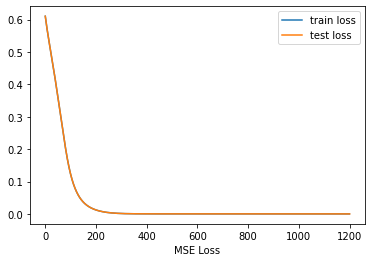

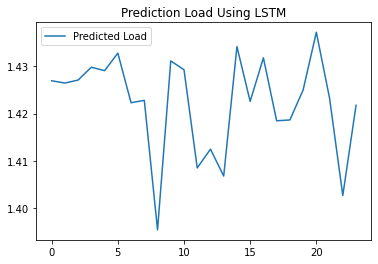

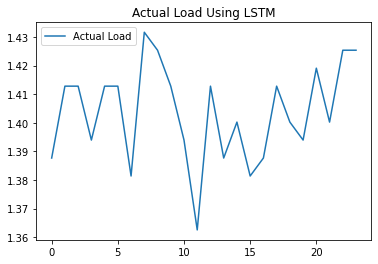

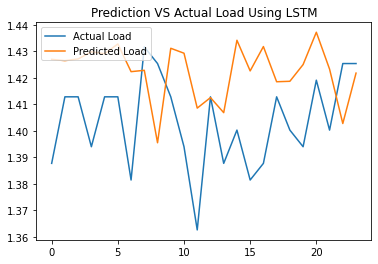

In [60]:
lstm.eval()
with torch.no_grad():
  test_predict_lstm = lstm(testX_lstm)


x_ax = [i for i in range(param_lstm['num_epochs'])]
plt.plot(train_loss_lstm.cpu().numpy(), label = "train loss")
plt.plot(test_loss_lstm.cpu(), label = "test loss")
plt.xlabel("epoch index")
plt.xlabel("MSE Loss")
plt.legend()
plt.show()

data_predict_lstm = test_predict_lstm.data.cpu().numpy()
dataY_plot_lstm = testY_lstm.cpu().numpy()

data_predict_lstm = data_predict_lstm[21]
dataY_plot_lstm = dataY_plot_lstm[21]

min_lstm = sc_lstm.data_min_[1]
max_lstm = sc_lstm.data_max_[1]

data_predict_lstm = data_predict_lstm * (max_lstm - min_lstm) +min_lstm
dataY_plot_lstm = dataY_plot_lstm * (max_lstm-min_lstm) + min_lstm



plt.plot(data_predict_lstm, label="Predicted Load")
plt.legend(loc="upper left")
plt.title("Prediction Load Using LSTM")
plt.show()

plt.plot(dataY_plot_lstm, label="Actual Load")
plt.legend(loc="upper left")
plt.title("Actual Load Using LSTM")
plt.show()

plt.plot(dataY_plot_lstm, label="Actual Load")
plt.plot(data_predict_lstm, label="Predicted Load")
plt.legend(loc="upper left")
plt.title("Prediction VS Actual Load Using LSTM")
plt.show()



In [61]:
from sklearn.metrics import mean_squared_error
testing_mse_lstm = mean_squared_error(data_predict_lstm, dataY_plot_lstm)
testing_mse_lstm

0.00075365254

### Model 2: GRU

In [62]:
class GRUNet(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRUNet, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')
        
        h_out, _ = self.gru(x, h_0)
        
        h_out = h_out[:, -1, :].to('cuda')
        
        out = self.fc(h_out).to('cuda')
        
        return out

In [63]:
param_gru = {
    'num_epochs':1200,
    'batch_num': 1,
    'learning_rate': 0.0008,
    'input_size': len(input_list),
    'hidden_size': 7,
    'num_layers': 1,
    'num_classes': 24, # dummy variable, same as pred_length
    'seq_length': 48,
    'pred_length':24,
    'train_size': 30000,
    'test_size': 6000,
}
sc_gru = MinMaxScaler()
training_data_gru = sc_gru.fit_transform(df_input)
x_gru, y_gru = sliding_windows(training_data_gru, param_gru['seq_length'], param_gru['pred_length'], sc_gru)
dataX_gru, dataY_gru, trainX_gru, trainY_gru, testX_gru, testY_gru = train_test_split(x_gru, y_gru, param_gru)

gru = GRUNet(param_gru['num_classes'], param_gru['input_size'], param_gru['hidden_size'], param_gru['num_layers'])
gru.to('cuda')
criterion_gru = torch.nn.MSELoss()    # mean-squared error for regression
optimizer_gru = torch.optim.Adam(gru.parameters(), lr=param_gru['learning_rate'])
param_gru["criterion"] = criterion_gru
param_gru["optimizer"] = optimizer_gru

gru, train_loss_gru, test_loss_gru = train_and_evaluate(param_gru, testX_gru, testY_gru, trainX_gru, trainY_gru, gru)

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.40917, test_loss: 0.40456
Epoch: 99, train_loss: 0.20746, test_loss: 0.20212
Epoch: 149, train_loss: 0.07915, test_loss: 0.07680
Epoch: 199, train_loss: 0.02685, test_loss: 0.02596
Epoch: 249, train_loss: 0.00849, test_loss: 0.00811
Epoch: 299, train_loss: 0.00259, test_loss: 0.00240
Epoch: 349, train_loss: 0.00090, test_loss: 0.00077
Epoch: 399, train_loss: 0.00043, test_loss: 0.00032
Epoch: 449, train_loss: 0.00030, test_loss: 0.00021
Epoch: 499, train_loss: 0.00027, test_loss: 0.00017
Epoch: 549, train_loss: 0.00026, test_loss: 0.00016
Epoch: 599, train_loss: 0.00025, test_loss: 0.00016
Epoch: 649, train_loss: 0.00025, test_loss: 0.00015
Epoch: 699, train_loss: 0.00025, test_loss: 0.00015
Epoch: 749, train_loss: 0.00025, test_loss: 0.00015
Epoch: 799, train_loss: 0.00024, test_loss: 0.00015
Epoch: 849, train_loss: 0.00024, test_loss: 0.00015
Epoch: 899, train_loss: 0.00024, test_loss: 0.00015
Epoch: 949, train_loss: 0.00024, test_loss: 0.00014
Epoch: 999, tr

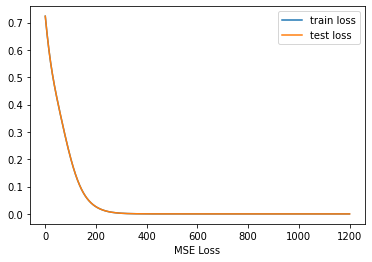

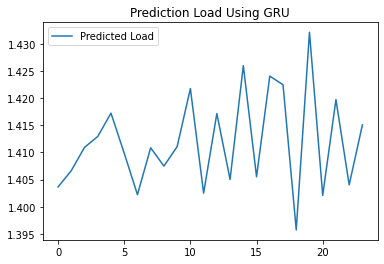

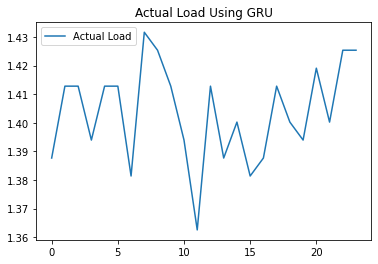

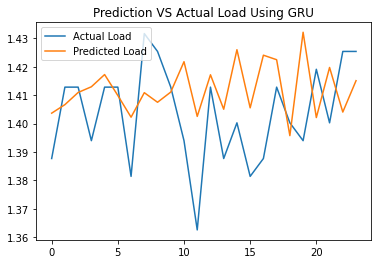

In [72]:
gru.eval()
with torch.no_grad():
  test_predict_gru = gru(testX_gru)


x_ax = [i for i in range(param_gru['num_epochs'])]
plt.plot(train_loss_gru.cpu().numpy(), label = "train loss")
plt.plot(test_loss_gru.cpu(), label = "test loss")
plt.xlabel("epoch index")
plt.xlabel("MSE Loss")
plt.legend()
plt.show()

data_predict_gru = test_predict_gru.data.cpu().numpy()
dataY_plot_gru = torch.squeeze(testY_gru).data.data.cpu().numpy()

data_predict_gru = data_predict_gru[21]
dataY_plot_gru = dataY_plot_gru[21]

min = sc_gru.data_min_[1]
max = sc_gru.data_max_[1]

data_predict_gru = data_predict_gru * (max - min) +min
dataY_plot_gru = dataY_plot_gru * (max-min) + min


plt.plot(data_predict_gru, label="Predicted Load")
plt.legend(loc="upper left")
plt.title("Prediction Load Using GRU")
plt.show()

plt.plot(dataY_plot_gru, label="Actual Load")
plt.legend(loc="upper left")
plt.title("Actual Load Using GRU")
plt.show()

plt.plot(dataY_plot_gru, label="Actual Load")
plt.plot(data_predict_gru, label="Predicted Load")
plt.legend(loc="upper left")
plt.title("Prediction VS Actual Load Using GRU")
plt.show()

In [71]:
from sklearn.metrics import mean_squared_error
testing_mse_gru = mean_squared_error(data_predict_gru, dataY_plot_gru)
testing_mse_gru

0.0005134815

### Model 3 : MLP

In [66]:
# class MLP(nn.Module):

#     def __init__(self, num_classes, input_size, hidden_size):
#         super(MLP, self).__init__()
        
#         self.num_classes = num_classes
#         self.input_size = input_size
#         self.hidden_size = hidden_size
        
#         self.layers = nn.Sequential(
#             nn.Linear(self.input_size, self.hidden_size),
#             nn.ReLU(),
#             nn.Linear(self.hidden_size, self.num_classes))

#     def forward(self, x):
        
#         output = self.layers(x)
#         return output

In [67]:
# param_mlp = {
#     'num_epochs':1000,
#     'batch_num': 1,
#     'learning_rate': 0.0005,
#     'input_size': 48* len(input_list),
#     'hidden_size': 5,
#     'num_layers': 1,
#     'num_classes': 24,
#     'seq_length': 48,
#     'pred_length':24,
#     'train_size': 50000,
#     'test_size': 10000,
# }

# sc_mlp = MinMaxScaler()
# training_data_mlp = sc_mlp.fit_transform(df_input)
# x_mlp, y_mlp = sliding_windows(training_data_mlp, param_mlp['seq_length'], param_mlp['pred_length'], sc_mlp)
# dataX_mlp, dataY_mlp, trainX_mlp, trainY_mlp, testX_mlp, testY_mlp = train_test_split(x_mlp, y_mlp, param_mlp)
# trainX_mlp = trainX_mlp.reshape(trainX_mlp.shape[0], trainX_mlp.shape[1] * trainX_mlp.shape[2])
# testX_mlp = testY_mlp.reshape(testX_mlp.shape[0], testX_mlp.shape[1] * testX_mlp.shape[2])

# mlp = MLP(param_mlp['num_classes'], param_mlp['input_size'], param_mlp['hidden_size'])
# mlp.to('cuda')
# criterion_mlp = torch.nn.MSELoss()    # mean-squared error for regression
# optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=param_mlp['learning_rate'])
# param_mlp["criterion"] = criterion_mlp
# param_mlp["optimizer"] = optimizer_mlp

# mlp, train_loss_mlp, test_loss_mlp = train_and_evaluate(param_mlp, testX_mlp, testY_mlp, trainX_mlp, trainY_mlp, mlp)

In [68]:
# mlp.eval()
# with torch.no_grad():
#   test_predict_mlp = mlp(testX_mlp)


# x_ax = [i for i in range(param_mlp['num_epochs'])]
# plt.plot(train_loss_mlp.cpu().numpy(), label = "train loss")
# plt.plot(test_loss_mlp.cpu(), label = "test loss")
# plt.xlabel("epoch index")
# plt.xlabel("MSE Loss")
# plt.legend()
# plt.show()

# data_predict_mlp = test_predict_mlp.data.cpu().numpy()
# dataY_plot_mlp = torch.squeeze(testY_mlp).data.data.cpu().numpy()

# data_predict_mlp = data_predict_mlp[21]
# dataY_plot_mlp = dataY_plot_mlp[21]

# min = sc_mlp.data_min_[1]
# max = sc_mlp.data_max_[1]

# data_predict_mlp = data_predict_mlp * (max - min) +min
# dataY_plot_mlp = dataY_plot_mlp * (max-min) + min



# plt.plot(data_predict_mlp, label="Predicted Load")
# plt.legend(loc="upper left")
# plt.title("Prediction Load Using GRU (8 hours)")
# plt.show()

# plt.plot(dataY_plot_mlp, label="Actual Load")
# plt.legend(loc="upper left")
# plt.title("Actual Load Using GRU (8 hours)")
# plt.show()

# plt.plot(dataY_plot_mlp, label="Actual Load")
# plt.plot(data_predict_mlp, label="Predicted Load")
# plt.legend(loc="upper left")
# plt.title("Prediction VS Actual Load Using GRU (8 hours)")
# plt.show()

In [69]:
# from sklearn.metrics import mean_squared_error
# testing_mse_mlp = mean_squared_error(data_predict_mlp, dataY_plot_mlp)
# testing_mse_mlp